<a href="https://colab.research.google.com/github/arthurperalta/peralta_projetos/blob/master/Projeto_Market_Basket_Analysis_de_uma_Mercearia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Market Basket Analysis de uma Mercearia**

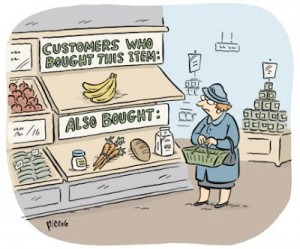

Olá, tudo bem?

Meu nome é Arthur Henrique Peralta ([LinkedIn](https://www.linkedin.com/in/arthurperalta/)), tenho 23 anos e estou no último semestre do curso de Economia.

Neste projeto irei elaborar uma análise exploratória dos dados, buscando *insights* interessantes e junto a isso aplicar o *Market Basket Analysis* para ajudar a equipe de Marketing a tomar melhores decisões em diversas áreas, como posicionamento dos produtos nas prateleiras e descontos combinados destes.


##**O que é Market Basket Analysis**

O *Market Basket Analysis* é a chave para achar associação entre itens. Com o avanço da tecnologia e com isso o aumento do número de dados, hoje vemos o *Market Basket Analysis* sendo aplicado em diversos locais e sites de e-commerce, instantaneamente, apresentando para você o famoso: *Quem comprou isso também comprou isso...* 

Porém podemos utilizar o *MBA* não apenas em sites de e-commerce, podemos aplicar até em uma pequena Mercearia, como mostrarei nesse projeto. Sendo útil para qualquer empresa que tenha uma base de dados de suas vendas mostrando quais itens foram vendidos em cada *Nota Fiscal*, o que hoje em dia é muito fácil de encontrar.

Agora que já dei uma breve introdução sobre o *Market Basket Analysis*, vamos começar nosso projeto e irei explicando as métricas enquanto executo o Projeto, conforme fiz nos meus outros projetos.


###**Início do Projeto**

Vamos começar importando as blibiotecas que iremos utilizar

In [54]:
#Import de blibiotecas

#Manipulação de dados
import pandas as pd
import numpy as np
import itertools

#Plot
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m

#Bibliotecas de MBA
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


Agora vamos fazer a importação dos dados.

Os dados foram encontrados no Kaggle e coloquei eles em meu *github* para facilitar a importação aqui no *Google Colab*.

In [55]:
#Import de dados
df = pd.read_csv('https://raw.githubusercontent.com/arthurperalta/peralta_projetos/master/data/MBA%20-%20Mercearia.csv')

Conferir se os dados vieram corretamente.

In [56]:
#Conferindo
df.head()

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Os dados brutos não estão de um jeito que nos ajude muito tanto na análise exploratória quanto no *MBA*, então vamos fazer aquela limpeza antes de começar as análises.

No *MBA* só precisamos saber os itens que foram comprados em cada transação, então a somatória de itens que está na coluna "Item(s)" não será útil para nós, podemos elimina-la.

In [57]:
#Eliminando coluna Item(s)
df.drop('Item(s)', axis = 1, inplace = True)

In [58]:
#Conferindo a remoção
df.head()

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,Item 10,Item 11,Item 12,Item 13,Item 14,Item 15,Item 16,Item 17,Item 18,Item 19,Item 20,Item 21,Item 22,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,other vegetables,whole milk,condensed milk,long life bakery product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Coluna eliminada, agora para facilitar nossa vida nas análises vamos colocar todos esses itens em apenas uma coluna conectada ao seu número fictício de transação

In [59]:
#Stack
df_stack = df.stack().reset_index()

In [60]:
#Conferindo o Stack
df_stack.head()

,level_0,level_1,0
0,0,Item 1,citrus fruit
1,0,Item 2,semi-finished bread
2,0,Item 3,margarine
3,0,Item 4,ready soups
4,1,Item 1,tropical fruit


Tudo certo com o nosso *stack*, porém e todas as colunas nulas? Viraram linhas nulas ou será que o *stack* já fez esse favor para nós?

In [61]:
#Conferindo Colunas Nulas
df_stack.isnull().sum()

level_0    0
level_1    0
0          0
dtype: int64

Sim, ele eliminou todas aquelas colunas nulas, evitando que se transformassem em linhas com valores nulos.

Se repararmos ele criou duas novas colunas:
- level_0
- level_1

A *level_0* seria o nosso número de transação fictício, e o *level_1* é o nome que estavam as colunas posterior ao *stack*. O *level_0* iremos utilizar, porém o *level_1* não, podemos excluir essa coluna.

In [62]:
#Excluindo coluna level_1
df_stack.drop('level_1', axis = 1, inplace = True)

In [63]:
#Conferindo
df_stack.head()

,level_0,0
0,0,citrus fruit
1,0,semi-finished bread
2,0,margarine
3,0,ready soups
4,1,tropical fruit


Vamos renomear o nome dessas colunas para ficar melhor de trabalhar

In [64]:
#Renomeando colunas
df_stack = df_stack.rename(columns = {'level_0':'Transação', 0:'Item'})

In [65]:
#Conferindo
df_stack.head()

,Transação,Item
0,0,citrus fruit
1,0,semi-finished bread
2,0,margarine
3,0,ready soups
4,1,tropical fruit


In [66]:
#Shape do dataset
print("O dataset possui com {} linhas e {} colunas.".format(df_stack.shape[0], df_stack.shape[1]))

O dataset está com 43367 linhas e 2 colunas.


In [67]:
#Número de Transações
print("O dataset possui {} transações realizadas.".format(df_stack['Transação'].nunique()))

O dataset tem 9835 transações realizadas.


Maravilha, vamos começar nossa análise exploratória.

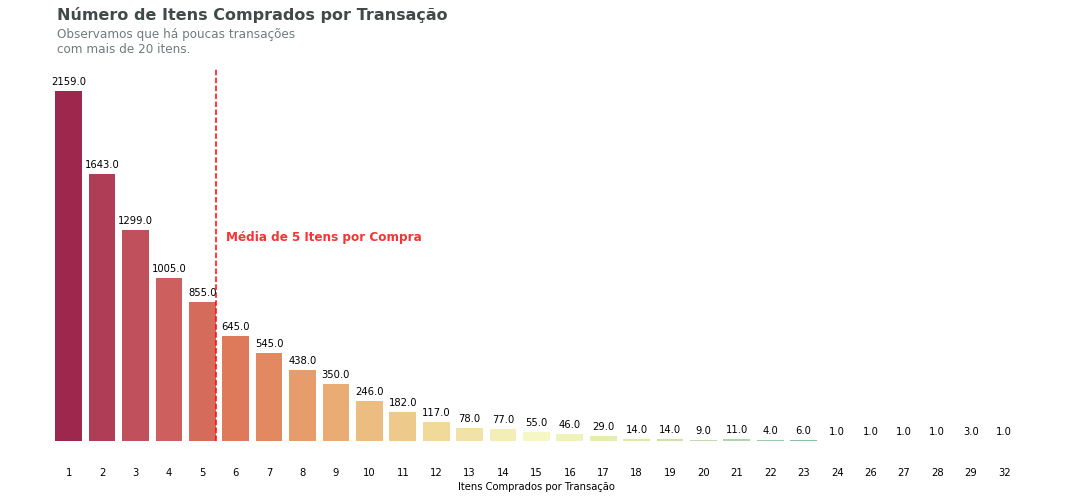

In [68]:
#Plot
plot1 = []
for k, v in df_stack['Transação'].value_counts().value_counts().items():
   plot1.append([k,v])
plot1 = pd.DataFrame(plot1, columns = ['Itens Comprados por Transação','v'])
fig, ax = plt.subplots(figsize = (15,7))
ax = sns.barplot(x = 'Itens Comprados por Transação', y = 'v', data = plot1, palette= 'Spectral')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=True) 
plt.vlines(x = df_stack['Transação'].value_counts().mean(), ymin = -0.5, ymax= 2300, linestyles = 'dashed', color = 'r')


for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 5
    va = 'bottom'
    label = "{}".format(y_value)
    ax.annotate(
      label,                      
      (x_value, y_value),         
      xytext=(0, space),          
      textcoords="offset points", 
      ha='center',                
      va=va)                      

plt.text(-0.35, 2600, 'Número de Itens Comprados por Transação',
         fontsize=16, 
         color='#424949',
         weight='bold')

plt.text(-0.35, 2550,
         "Observamos que há poucas transações\n"
         "com mais de 20 itens.\n",
         verticalalignment="top",
         fontsize=12,
         color='#707B7C')

plt.text(df_stack['Transação'].value_counts().mean() + .3 , 1300,
         "Média de 5 Itens por Compra",
         verticalalignment="top",
         fontsize=12,
         weight = 'bold',
         color='#F73434')

fig.tight_layout()
plt.show()                     

Nesse gráfico podemos observar que a média de itens comprados é 5, e há poucas transações com mais de 20 itens.

Isso quer dizer que as pessoas procuram mais essa mercearia para compras rápidas, que devem estar faltando em sua casa.

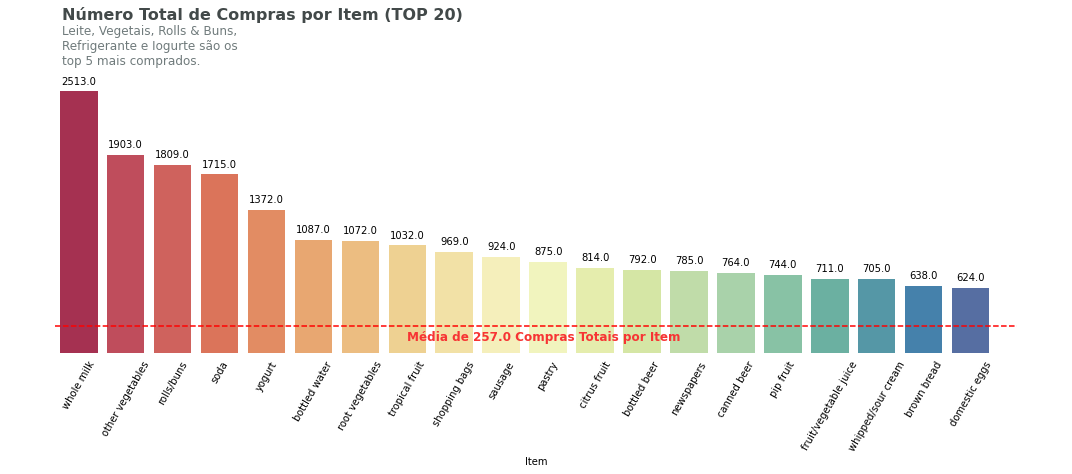

In [69]:
#Plot
plot2 = []
for k, v in df_stack['Item'].value_counts().items():
   plot2.append([k,v])
plot2 = pd.DataFrame(plot2[:20], columns = ['Item','v'])
fig, ax = plt.subplots(figsize = (15,7))
ax = sns.barplot(x = 'Item', y = 'v', data = plot2, palette= 'Spectral')
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=True,
    labelrotation = 60) 
plt.hlines(y = df_stack['Item'].value_counts().mean(), xmin = -0.5, xmax= 20, linestyles = 'dashed', color = 'r')


for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 5
    va = 'bottom'
    label = "{}".format(y_value)
    ax.annotate(
      label,                      
      (x_value, y_value),         
      xytext=(0, space),          
      textcoords="offset points", 
      ha='center',                
      va=va)                      

plt.text(-0.35, 3200, 'Número Total de Compras por Item (TOP 20)',
         fontsize=16, 
         color='#424949',
         weight='bold')

plt.text(-0.35, 3150,
         "Leite, Vegetais, Rolls & Buns, \n"
         "Refrigerante e Iogurte são os\n"
         "top 5 mais comprados.",
         verticalalignment="top",
         fontsize=12,
         color='#707B7C')

plt.text(7, df_stack['Item'].value_counts().mean() -50,
         "Média de {} Compras Totais por Item".format(round(df_stack['Item'].value_counts().mean(),0)),
         verticalalignment="top",
         fontsize=12,
         weight = 'bold',
         color='#F73434')

fig.tight_layout()
plt.show()                     

Aqui vemos que o leite é, disparado, o item mais comprado da mercearia, em seguida vem um tipo de vegetais, um tipo de pão, refrigerante e o iogurte.

A média de compras totais por item fica em 257, sendo assim os top 20 itens estão muito acima da média. O que nos mostra que muitos itens com poucas vendas estão puxando essa média para baixo, conseguimos analisar melhor em um boxplot.

Vamos fazer isso.

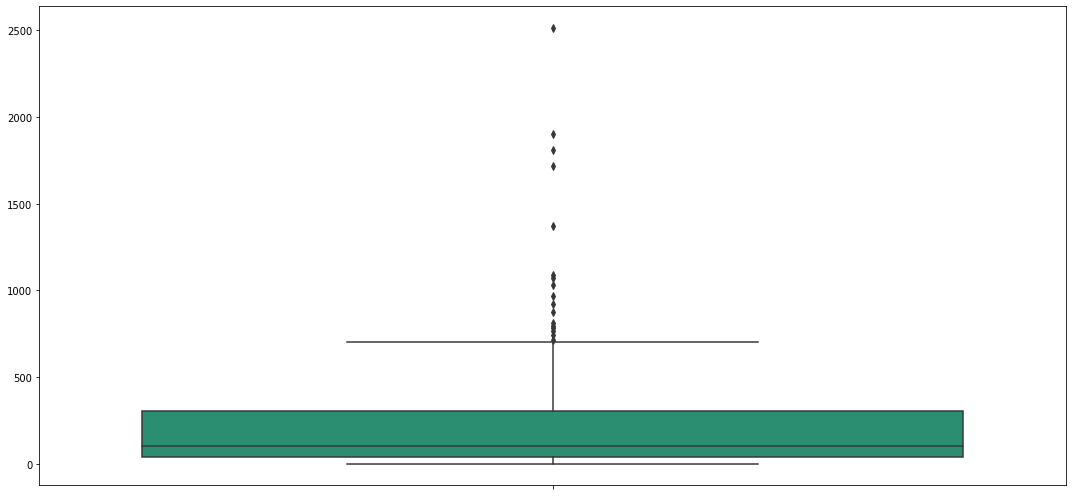

As estatísticas podem ser observadas numericamente a baixo:

count     169.000000
mean      256.609467
std       379.006378
min         1.000000
25%        38.000000
50%       103.000000
75%       305.000000
max      2513.000000
Name: Item, dtype: float64


In [70]:
#Plot3
fig, ax = plt.subplots(figsize = (15,7))
sns.boxplot(y = df_stack['Item'].value_counts().values,data =df_stack['Item'].value_counts(), palette= 'Dark2')
fig.tight_layout()
plt.show()  
print('As estatísticas podem ser observadas numericamente a baixo:\n\n{}'.format(df_stack['Item'].value_counts().describe()))

Vemos que o desvio padrão está muito grande, isso acontece devido aos itens que mais saem da mercearia, vemos que o 3º quartil tem o valor de 305 itens.

Isso nos mostra que muitas pessoas vão a Mercearia em busca mais dos itens demonstrandos no top 20, e acabam levando esses itens que menos saem como um a mais.

Agora que já entendemos melhor nossos dados, vamos começar o pré-processamento destes para aplicar o modelo de *MBA*.

##**Pré-Processamento**

O algoritmo que iremos utilizar para criar nosso modelo de *MBA* necessita que os dados estejam em um tipo de matriz esparsa, onde a transação que tiver o item X comprado, terá a coluna deste item com valor 1 e se não tiver comprado a coluna do item deve estar com valor 0.

Então vamos colocar a mão na massa e começar nosso pré-processamento.

In [71]:
#Pré-processamento
mba = df_stack.groupby(['Transação', 'Item'])['Item'].count().unstack().reset_index().fillna(0).set_index('Transação')

In [72]:
#Conferindo se está tudo ok com os nossos dados
mba.head()

Item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Transação,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Para não haver dúvidas que nossa matriz só esta com 0 ou 1, vamos aplicar uma função que transforma valores acima de 1, em 1.

In [73]:
#Aplicando função
def zero_to_one(x):
  if x <= 0:
    return 0
  if x>= 1:
    return 1
mba = mba.applymap(zero_to_one)

In [74]:
#conferindo
mba.head()

Item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,...,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,sound storage medium,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Transação,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Maravilha!!!

Agora antes de continuarmos, vamos entender melhor o *MBA* e suas métricas.

As Regras de Associação, que são utilizadas no *MBA*, representam os padrões existentes nas transações de um determinado *dataset*.

Ele trabalha com uma regra que assume uma forma de *if X then Y*, se a pessoa compra X ela compra Y, e qual a probabilidade disto acontecer.

As métricas dos nossos algoritmos baseiam-se em:
- Suporte: que seria o número de vezes que um determinado aparece na transação, dividido pelo número total de transações de nosso *dataset*.

- Confiança: a confiança seria a precisão mínima especificada de aquele determinado evento ocorrer dado o resultado X da nossa métrica suporte. Por exemplo: se o nosso suporte deu 33%, a confiança indica a ocorrência de dois itens (Y e Z) terem sidos comprados juntos dentro desse suporte de 33%. 

- Lift: o *lift* seria o indicador de frequencia dado itens Y e Z, por exemplo. Por exemplo, se o suporte deu 33% e a confiaça 66%, quando aplicamos o *lift* de Y para Z, aplicamos uma divisão de 66%/33%, dando o resultado de 2, o que indica que os clientes que comprar Y possuem uma chance duas vezes maior de comprar Z.

Agora que já resumimos as métricas do *MBA* vamos fazer a aplicação destas regras de associação.

Como nosso dataset não é grande, e além disso possui muitos itens que são comprados em maior quantidade enquanto outros não, vamos fazer análise com dois valores de *min_support*, um com um valor de 3%, para pegar os itens realmente mais utilizados, e outra com valor de 1% para pegar mais associação de outros tipos de itens.

In [82]:
#Suporte dos itens 3%
itens_frequentes_3 = apriori(mba, min_support = 0.03, use_colnames = True)

In [84]:
#Conferindo o DataFrame de item e suporte 3%
itens_frequentes_3

,support,itemsets
0,0.033452,(UHT-milk)
1,0.052466,(beef)
2,0.033249,(berries)
3,0.080529,(bottled beer)
4,0.110524,(bottled water)
...,...,...
58,0.048907,"(root vegetables, whole milk)"
59,0.040061,"(soda, whole milk)"
60,0.042298,"(tropical fruit, whole milk)"
61,0.032232,"(whole milk, whipped/sour cream)"


In [85]:
#Suporte dos itens 1%
itens_frequentes_1 = apriori(mba, min_support = 0.01, use_colnames= True)

In [86]:
#Conferindo o DataFrame de Item e Suporte 1%
itens_frequentes_1

,support,itemsets
0,0.033452,(UHT-milk)
1,0.017692,(baking powder)
2,0.052466,(beef)
3,0.033249,(berries)
4,0.026029,(beverages)
...,...,...
328,0.011998,"(root vegetables, tropical fruit, whole milk)"
329,0.014540,"(root vegetables, whole milk, yogurt)"
330,0.010473,"(soda, whole milk, yogurt)"
331,0.015150,"(tropical fruit, whole milk, yogurt)"


Agora que criamos os *DataFrames* de itens com seus suportes, podemos aplicar o algoritmo de regras de associação para retirar nossos insights.

Vamos começar aplicando em nosso *DataFrame* que utilizamos o valor de 3% como nosso *min_support*

In [97]:
#Criando Algoritmo de Regra de Associação 3%
regras_associacao_3 = association_rules(itens_frequentes_3, metric = 'lift', min_threshold = 1)

In [131]:
#Associação
regras_associacao_3.sort_values('lift', ascending = False).style.bar(subset = ['support','confidence','lift'], color = '#FCAC77')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7,frozenset({'other vegetables'}),frozenset({'root vegetables'}),0.193493,0.108998,0.047382,0.244877,2.246605,0.026291,1.179941
6,frozenset({'root vegetables'}),frozenset({'other vegetables'}),0.108998,0.193493,0.047382,0.434701,2.246605,0.026291,1.426693
18,frozenset({'sausage'}),frozenset({'rolls/buns'}),0.093950,0.183935,0.030605,0.325758,1.771048,0.013324,1.210344
19,frozenset({'rolls/buns'}),frozenset({'sausage'}),0.183935,0.093950,0.030605,0.166390,1.771048,0.013324,1.086899
8,frozenset({'other vegetables'}),frozenset({'tropical fruit'}),0.193493,0.104931,0.035892,0.185497,1.767790,0.015589,1.098913
9,frozenset({'tropical fruit'}),frozenset({'other vegetables'}),0.104931,0.193493,0.035892,0.342054,1.767790,0.015589,1.225796
31,frozenset({'whipped/sour cream'}),frozenset({'whole milk'}),0.071683,0.255516,0.032232,0.449645,1.759754,0.013916,1.352735
30,frozenset({'whole milk'}),frozenset({'whipped/sour cream'}),0.255516,0.071683,0.032232,0.126144,1.759754,0.013916,1.062323
27,frozenset({'whole milk'}),frozenset({'root vegetables'}),0.255516,0.108998,0.048907,0.191405,1.756031,0.021056,1.101913
26,frozenset({'root vegetables'}),frozenset({'whole milk'}),0.108998,0.255516,0.048907,0.448694,1.756031,0.021056,1.350401


Agora que aplicamos as regras de associação ao nosso conjunto de dados com suporte mínimo de 3%, podemos retirar os insights:

- Quando o cliente compra o item *other vegetables* a chance de ele comprar o *root vegetables* aumenta em duas vezes, e vice-versa, conforme observamos no valor de *lift* deles. Porém o item *root vegetables* tende a ser o chamariz do *other vegetables* pois possui uma confiança maior.
- Conseguimos observar padrões semelhantes em alguns outros itens, porém nenhum com o valor de *lift* maior que 2, mas mesmo assim, perto destes valores. Como por exemplo: *sausage e roll & buns, other vegetables e tropical fruit, whipped/sour cream e whole milk, e em todos os outros itens que possuem valor de lift maior que 1, porém esses foram os que mais chamaram atenção.
- A maior confiança vem da relação entre *root vegetables* e *whole milk* o que nos mostra que a pessoa que coloca o *root vegetables* no carrinho tende a levar o *whole milk* junto, sendo assim podemos colocar o *whole milk* posicionado de um jeito que o cliente tenha que passar na seção de *root vegetables* para já consquistar a venda deste.
- Vemos que o leite possui associação com muitos itens, já tinhamos visto que o leite é o item mais comprado na mercearia, seu maior *lift* de associação é com o *whipped/sour cream*, conforme supracitado. Porém o fato de ele estar associado a diversos outros itens, mostra que ele é um chamariz para essa mercearia. Aplicando um desconto neste item pode aumentar o número de clientes dentro dessa Mercearia e consequentemente a aquisição de outros produtos, como vimos, a média de itens comprados é 5.

Agora vamos analisar o nosso *DataFrame* que criamos utilizando o *min_support* de 1%. Assim conseguimos retirar mais insights que estão escondidos em nossos dados.

Como diminuímos o valor mínimo do nosso suporte, podemos aumentar o *threshold* do *lift*, pegando apenas aquilo que é realmente interessante para nós, pois como o valor de suporte é baixo, não conseguimos extrair tanta certeza, pois há pequenas amostras destas associações, porém não deixa de ser informação relevante para o Gestor.

In [134]:
#Criando Algoritmo de Regras de Associação 1%
regras_associacao_1 = association_rules(itens_frequentes_1, metric = 'lift', min_threshold = 3)

In [135]:
#Associação
regras_associacao_1.sort_values('lift', ascending = False).style.bar(subset = ['support','confidence','lift'], color = '#FCAC77')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,"frozenset({'whole milk', 'yogurt'})",frozenset({'curd'}),0.056024,0.053279,0.010066,0.179673,3.372304,0.007081,1.154078
7,frozenset({'curd'}),"frozenset({'whole milk', 'yogurt'})",0.053279,0.056024,0.010066,0.188931,3.372304,0.007081,1.163866
3,"frozenset({'citrus fruit', 'other vegetables'})",frozenset({'root vegetables'}),0.028876,0.108998,0.010371,0.359155,3.295045,0.007224,1.390354
4,frozenset({'root vegetables'}),"frozenset({'citrus fruit', 'other vegetables'})",0.108998,0.028876,0.010371,0.095149,3.295045,0.007224,1.073242
12,"frozenset({'other vegetables', 'yogurt'})",frozenset({'whipped/sour cream'}),0.043416,0.071683,0.010168,0.234192,3.267062,0.007056,1.212206
13,frozenset({'whipped/sour cream'}),"frozenset({'other vegetables', 'yogurt'})",0.071683,0.043416,0.010168,0.141844,3.267062,0.007056,1.114697
9,"frozenset({'other vegetables', 'tropical fruit'})",frozenset({'root vegetables'}),0.035892,0.108998,0.012303,0.342776,3.144780,0.008391,1.355705
10,frozenset({'root vegetables'}),"frozenset({'other vegetables', 'tropical fruit'})",0.108998,0.035892,0.012303,0.112873,3.144780,0.008391,1.086776
0,frozenset({'root vegetables'}),frozenset({'beef'}),0.108998,0.052466,0.017387,0.159515,3.040367,0.011668,1.127366
1,frozenset({'beef'}),frozenset({'root vegetables'}),0.052466,0.108998,0.017387,0.331395,3.040367,0.011668,1.332628


Como diminuimos o valor de *min_support* conseguimos pegar associações de até 3 itens, o que é muito interessante.

Utilizamos o *threshold* no *lift* de 3, o que nos mostra associações de um aumento de chance de até 3 vezes com determinados itens.

Porém como supracitado, o valor de suporte está baixo, o que significa que não houve tantas compras com estes itens em conjunto **ou** um destes itens não estão saindo tanto, porém possuem uma associação que se bem utilizada pode aumentar a vendas deste e consequentemente o aumento do faturamento da Mercearia, então devem ser informadas estas associações ao Gestor buscando o aumento da venda destes. 

- Clientes que colocam em seu carrinho de compras os itens *whole milk* e *yogurt* aumentam em 3x a chance deste levar o *curd* junto. Assim também é com a associação entre *citrus fruit, other vegetables, citrus fruit* e *root vegetables*, estes devem ser mantidos na mesma seção e com descontos interagindo entre si, aumentando as vendas destes.

- Com base no que já foi supracitado, o desconto no *whole milk* como chamariz da Mercearia e o *Yogurt* posicionado perto dele, aumenta em 3 vezes a chance deste levar o *curd*, fazendo com que seja inteligente colocarmos o *curd* em uma posição vista perto destes dois itens.

- O item *beef* não saiu no nosso gráfico de top 20 itens mais vendidos da Mercearia, o que já faz com que a sua métrica de suporte seja baixa, porém o interessante é que mesmo com seu suporte baixo, ele possui uma grande associação com o item *root vegetables*, o que está na 7º posição de item mais vendido, mas como sua confiança é maior, vemos que na verdade o *beef* que chama o *root vegetables*, podendo fazer um desconto mútuo para aumentar a venda de ambos, ou até posicionar o *root vegetables* em uma seção perto do açougue, aumentando ainda mais suas vendas

#**Conclusão**

O uso de dados para tomada de decisões se tornou imprescindível nos dias de hoje. Com o aumento da concorrência, tomada de decisões rápidas e inteligentes podem ser a diferença entre o sucesso do negócio e o fracasso total. Hoje em dia é tudo muito rápido e quem não conseguir acompanhar acaba ficando para trás, seja pessoa física ou pessoa jurídica.

O *Market Basket Analysis* já é muito utilizado por gigantes do e-commerce, porém ainda não é utilizado em pequenos negócios que podem aproveitar **muito** as informações que estes trazem, podendo posicionar melhor seus produtos e fazer descontos que levem a venda não apenas de um determinado item X, mas também do item Y, que é afetado pelo desconto do item X e na maioria das vezes o Gestor do negócio não faz nem ideia dessa associação.

Essas informações só podem ser obtidas com o armazenamento dos dados, por esse motivo a cultura data driven está cada vez mais em alta, as informações que podemos retirar dos dados são **pedras preciosas** para o conhecimento da clientela de determinado negócio e como estes reagem as tomadas de decisões da empresa.